In [1]:
import os
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import tidalUtl.InterfaceSQL as isq
import tidalUtl.PrpUtl as prp
import tidalUtl.EdaUtl as eda
import tidalUtl.VslUtl as vsl
import tidalUtl.ImgUtl as img

# loading some basic packages for testing
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
#import xgboost as xgb

from tqdm.notebook import tqdm
from skimage import exposure, io
import cv2
from glob import glob

import random
from random import randint

In [2]:
# config
INPUT = "/home/tidal/ML_Data/VinBigData/archive"
OUTPUT = "/home/tidal/ML_Data/VinBigData/output"

## Loading

In [3]:
trainMetaFeature = pd.read_csv(INPUT + '/train_meta.csv')#https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/207955
sampleSubmission = pd.read_csv(INPUT + '/sample_submission.csv')

trainFeature_ = pd.read_csv(INPUT + '/train.csv')
trainFeature = pd.merge(trainFeature_, trainMetaFeature, on="image_id", how="inner")
del trainFeature_
del trainMetaFeature

In [4]:
imgPathsTrain = glob(f"{INPUT}/train/*.png")
imgPathsTest = glob(f"{INPUT}/test/*.png")

In [5]:
imgPathsTrain

['/home/tidal/ML_Data/VinBigData/archive/train/7be2d2fc4e5821cbf3f5fb7d7d3a3c8e.png',
 '/home/tidal/ML_Data/VinBigData/archive/train/91bd34988db056a443f2652abd2c9f81.png',
 '/home/tidal/ML_Data/VinBigData/archive/train/a1a0efe48f448842f15fe27f29deacde.png',
 '/home/tidal/ML_Data/VinBigData/archive/train/ca691809344aa18a9597b0d72fb8353d.png',
 '/home/tidal/ML_Data/VinBigData/archive/train/cde51d108787b5b9de168de191c2e763.png',
 '/home/tidal/ML_Data/VinBigData/archive/train/78caa1abf8556f8827f5735e02bfc400.png',
 '/home/tidal/ML_Data/VinBigData/archive/train/62e1eedc69d6ad4a5119578eced73aac.png',
 '/home/tidal/ML_Data/VinBigData/archive/train/7346308962a682d3671080d546e6fbdb.png',
 '/home/tidal/ML_Data/VinBigData/archive/train/84fe236b6e242fd16ee90fbd9fbf0c26.png',
 '/home/tidal/ML_Data/VinBigData/archive/train/6b2adaa77cf6ef3d3cea8b8b54f88df2.png',
 '/home/tidal/ML_Data/VinBigData/archive/train/d9a1a2d02ee9634a0486de53f820fadd.png',
 '/home/tidal/ML_Data/VinBigData/archive/train/67d9c7b

In [6]:
print(len(imgPathsTrain))
print(len(imgPathsTest))

15000
3000


In [7]:
trainFeature

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,dim0,dim1
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2580,2332
1,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R15,NaN,NaN,NaN,NaN,2580,2332
2,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R16,NaN,NaN,NaN,NaN,2580,2332
3,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,3159,2954
4,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R13,NaN,NaN,NaN,NaN,3159,2954
...,...,...,...,...,...,...,...,...,...,...
67909,ae86eabab95525b41b8e79883ff1cef9,No finding,14,R5,NaN,NaN,NaN,NaN,3055,2864
67910,ae86eabab95525b41b8e79883ff1cef9,No finding,14,R7,NaN,NaN,NaN,NaN,3055,2864
67911,839b2311ffad9bdd9aa98c74aad6e251,No finding,14,R15,NaN,NaN,NaN,NaN,3000,2801
67912,839b2311ffad9bdd9aa98c74aad6e251,No finding,14,R17,NaN,NaN,NaN,NaN,3000,2801


In [8]:
trainFeature[trainFeature.class_name != "No finding"]

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,dim0,dim1
6,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2336,2080
7,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,R9,1789.0,1729.0,1875.0,1992.0,2336,2080
8,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,R9,1789.0,1729.0,1875.0,1992.0,2336,2080
9,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R9,692.0,1375.0,1657.0,1799.0,2336,2080
10,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R8,689.0,1313.0,1666.0,1763.0,2336,2080
...,...,...,...,...,...,...,...,...,...,...
67774,52951d7de2485aba8ed62629eee4d254,Other lesion,9,R9,303.0,1442.0,383.0,1508.0,2880,2304
67775,52951d7de2485aba8ed62629eee4d254,Cardiomegaly,3,R8,734.0,1571.0,1614.0,1892.0,2880,2304
67848,1224f07d895107573588225f692e94f9,Aortic enlargement,0,R10,999.0,716.0,1276.0,988.0,2264,2040
67849,1224f07d895107573588225f692e94f9,Aortic enlargement,0,R8,1046.0,688.0,1272.0,979.0,2264,2040


# Image

In [9]:
icTrain = io.imread_collection(imgPathsTrain)
icTest = io.imread_collection(imgPathsTest)
print(type(icTrain))
print(type(icTrain[0]))

<class 'skimage.io.collection.ImageCollection'>
<class 'numpy.ndarray'>


In [10]:
icTrain[0]

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 4, 14, 22, ...,  1,  1,  1],
       [ 5, 12, 17, ...,  1,  1,  1],
       [ 3,  8, 16, ...,  1,  1,  1]], dtype=uint8)

In [11]:
def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()
    

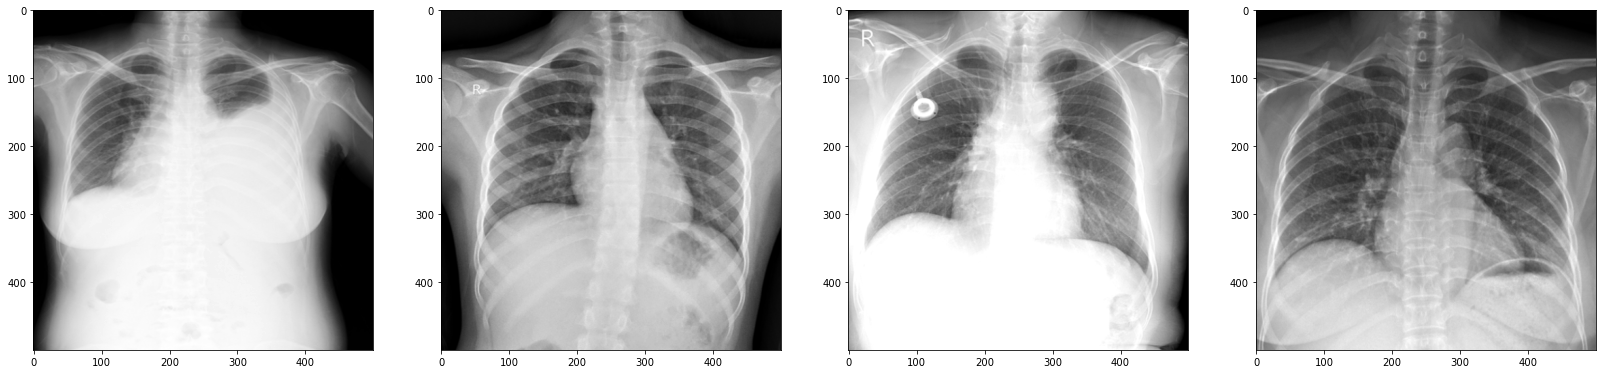

In [12]:
imgs = [im for im in icTrain[:4]]
plot_imgs(imgs)

### equalize_hist

画像のピクセルの強さのヒストグラムを正規分布に近づける。（コントラストが出て見やすくなる）


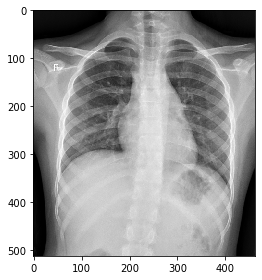

In [13]:
img = icTrain[1]
io.imshow(img)

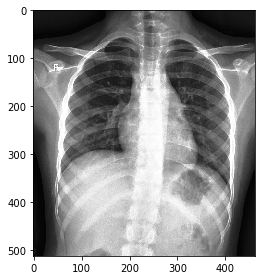

In [14]:
io.imshow(exposure.equalize_hist(img))

## plot bounding box

In [15]:
trainFeature[trainFeature.class_name != "No finding"].reset_index(drop=True)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,dim0,dim1
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2336,2080
1,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,R9,1789.0,1729.0,1875.0,1992.0,2336,2080
2,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,R9,1789.0,1729.0,1875.0,1992.0,2336,2080
3,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R9,692.0,1375.0,1657.0,1799.0,2336,2080
4,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R8,689.0,1313.0,1666.0,1763.0,2336,2080
...,...,...,...,...,...,...,...,...,...,...
36091,52951d7de2485aba8ed62629eee4d254,Other lesion,9,R9,303.0,1442.0,383.0,1508.0,2880,2304
36092,52951d7de2485aba8ed62629eee4d254,Cardiomegaly,3,R8,734.0,1571.0,1614.0,1892.0,2880,2304
36093,1224f07d895107573588225f692e94f9,Aortic enlargement,0,R10,999.0,716.0,1276.0,988.0,2264,2040
36094,1224f07d895107573588225f692e94f9,Aortic enlargement,0,R8,1046.0,688.0,1272.0,979.0,2264,2040


In [16]:
finding_df = trainFeature[trainFeature.class_name != "No finding"].reset_index(drop=True)
imgs = []
img_ids = finding_df['image_id'].values
class_ids = finding_df['class_id'].unique()

# map label_id to specify color
label2color = {class_id:[randint(0,255) for i in range(3)] for class_id in class_ids}
thickness = 3
scale = 5


#imageのid(画像名)取得
img_id = img_ids[10000]
#画像パス生成
imgPath = f"{INPUT}/train/{img_id}.png"
#画像（np.array）生成
img = io.imread(imgPath)

#Dicom形式時点でのボックスの位置
boxesDicom  = finding_df.loc[finding_df['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values
#リサイズ比
rate_0 = img.shape[0]/finding_df.loc[finding_df['image_id'] == img_id, ['dim0']].values.tolist()[0][0]
#リサイズ後のボックスの位置
boxes = np.round(boxesDicom*rate_0)
#label生成
labels = finding_df.loc[finding_df['image_id'] == img_id, ['class_id']].values.squeeze()

In [25]:
rate_0

0.16825501150180744

In [17]:
finding_df[finding_df.dim0 < finding_df.dim1]

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,dim0,dim1
217,04bb8bd7ee6f88a16623fe5c6dd4da91,Pleural effusion,10,R10,655.0,1188.0,1354.0,2049.0,2623,3320
218,04bb8bd7ee6f88a16623fe5c6dd4da91,Pulmonary fibrosis,13,R9,820.0,1412.0,1286.0,1475.0,2623,3320
219,04bb8bd7ee6f88a16623fe5c6dd4da91,Lung Opacity,7,R9,2121.0,1411.0,2462.0,1706.0,2623,3320
220,04bb8bd7ee6f88a16623fe5c6dd4da91,Pleural effusion,10,R8,1707.0,1437.0,2591.0,2087.0,2623,3320
221,04bb8bd7ee6f88a16623fe5c6dd4da91,Pleural effusion,10,R8,596.0,1440.0,1441.0,2087.0,2623,3320
...,...,...,...,...,...,...,...,...,...,...
35876,fc7a5aa2e71f3a9cd2ee1a871303239e,Other lesion,9,R10,2418.0,1397.0,2573.0,1663.0,2604,3004
35877,fc7a5aa2e71f3a9cd2ee1a871303239e,Cardiomegaly,3,R10,1121.0,1672.0,2342.0,2099.0,2604,3004
35890,f8f1d67dcbeb7badd781e2a0f30e020e,Cardiomegaly,3,R9,737.0,914.0,1590.0,1356.0,2082,2126
35891,f8f1d67dcbeb7badd781e2a0f30e020e,Cardiomegaly,3,R8,728.0,876.0,1581.0,1306.0,2082,2126


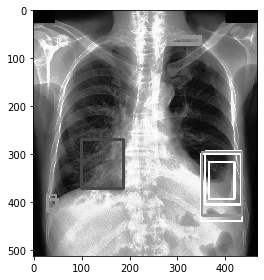

In [24]:
num = 400 #画像の番号

finding_df = trainFeature[trainFeature.class_name != "No finding"]
imgs = []
img_ids = finding_df['image_id'].values
class_ids = finding_df['class_id'].unique()

# map label_id to specify color
label2color = {class_id:[randint(0,255) for i in range(3)] for class_id in class_ids}
thickness = 3
scale = 5

#imageのid(画像名)取得
img_id = img_ids[num]
#画像パス生成
imgPath = f"{INPUT}/train/{img_id}.png"
#画像（np.array）生成
img = io.imread(imgPath)

#Dicom形式時点でのボックスの位置
boxesDicom  = finding_df.loc[finding_df['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values
#リサイズ比
rate_0 = img.shape[0]/finding_df.loc[finding_df['image_id'] == img_id, ['dim0']].values.tolist()[0][0]
#リサイズ後のボックスの位置
boxes = np.round(boxesDicom*rate_0)
#label生成
labels = finding_df.loc[finding_df['image_id'] == img_id, ['class_id']].values.squeeze()

#対象の画像に四角形を付与
for label_id, box in zip(labels, boxes):
    color = label2color[label_id]
    img = cv2.rectangle(
        img,
        (int(box[0]), int(box[1])),
        (int(box[2]), int(box[3])),
        color, thickness)
    #img = cv2.resize(img, (500,500))
    #imgs.append(img)
    
#plot_imgs(imgs, cmap=None)
io.imshow(exposure.equalize_hist(img))

# CSV

In [28]:
trainFeature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67914 entries, 0 to 67913
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    67914 non-null  object 
 1   class_name  67914 non-null  object 
 2   class_id    67914 non-null  int64  
 3   rad_id      67914 non-null  object 
 4   x_min       36096 non-null  float64
 5   y_min       36096 non-null  float64
 6   x_max       36096 non-null  float64
 7   y_max       36096 non-null  float64
 8   dim0        67914 non-null  int64  
 9   dim1        67914 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 5.7+ MB


In [29]:
sampleSubmission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_id          3000 non-null   object
 1   PredictionString  3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


## Unique feature Check

In [30]:
df = trainFeature
clmnNm = "image_id"
eda.chkUnique(df, clmnNm)

image_id is not unique.


,uni_image_id,nunique
0,03e6ecfa6f6fb33dfeac6ca4f9b459c9,57
1,fa109c087e46fe1ea27e48ce6d154d2f,52
2,e31be972e181987a8600a8700c1ebe88,48
3,6d5acf3f8a973a26844d617fffe72998,46
4,3a302fbbbf3364aa1a7731b59e6b98ec,46
...,...,...
14995,745dd954945d76615e8785c39b91b6fb,3
14996,4a7500b067151fc94a966c07be7f4779,3
14997,835413c68fe1d065629f748ed4e67205,3
14998,52a31de57ce1d76896720fe4e047dac8,3


In [31]:
df = trainFeature
clmnNm = "image_id"
eda.chkUnique(df, clmnNm)

image_id is not unique.


,uni_image_id,nunique
0,03e6ecfa6f6fb33dfeac6ca4f9b459c9,57
1,fa109c087e46fe1ea27e48ce6d154d2f,52
2,e31be972e181987a8600a8700c1ebe88,48
3,6d5acf3f8a973a26844d617fffe72998,46
4,3a302fbbbf3364aa1a7731b59e6b98ec,46
...,...,...
14995,745dd954945d76615e8785c39b91b6fb,3
14996,4a7500b067151fc94a966c07be7f4779,3
14997,835413c68fe1d065629f748ed4e67205,3
14998,52a31de57ce1d76896720fe4e047dac8,3


In [32]:
trainFeature.nunique()

image_id      15000
class_name       15
class_id         15
rad_id           17
x_min          2521
y_min          2570
x_max          2644
y_max          2714
dim0           1127
dim1           1036
dtype: int64

画像が重複している.

In [33]:
trainFeature[trainFeature.image_id == "03e6ecfa6f6fb33dfeac6ca4f9b459c9"]

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,dim0,dim1
5214,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R9,562.0,2045.0,629.0,2112.0,2992,2776
5215,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R10,2046.0,778.0,2308.0,1111.0,2992,2776
5216,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R10,1766.0,634.0,2645.0,2567.0,2992,2776
5217,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R8,2239.0,1592.0,2336.0,1690.0,2992,2776
5218,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R8,515.0,1732.0,589.0,1799.0,2992,2776
5219,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R8,2030.0,792.0,2358.0,1237.0,2992,2776
5220,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R9,628.0,1186.0,696.0,1247.0,2992,2776
5221,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R8,2018.0,1302.0,2088.0,1372.0,2992,2776
5222,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R9,1775.0,750.0,1852.0,831.0,2992,2776
5223,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R8,424.0,1349.0,493.0,1418.0,2992,2776


## Counting (Categorical Feature)

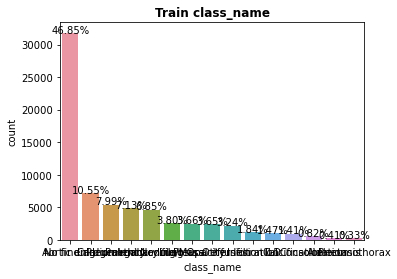

In [35]:
vsl.histCategory(trainFeature,'class_name')

In [37]:
trainFeature['class_name'].value_counts()

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

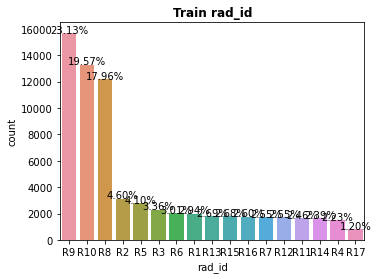

In [38]:
vsl.histCategory(trainFeature,'rad_id')

In [39]:
trainFeature['rad_id'].value_counts()

R9     15708
R10    13292
R8     12198
R2      3121
R5      2783
R3      2285
R6      2041
R1      1995
R13     1824
R15     1823
R16     1763
R7      1733
R12     1729
R11     1670
R14     1624
R4      1513
R17      812
Name: rad_id, dtype: int64